In [3]:
import sys

python_path = ['/home/claudio/.local/lib64/python3.6/site-packages','/home/sebastian/.local/lib64/python3.6/site-packages','/home/sebastian/.local/lib/python3.6/site-packages','/home/sebastian/.local/lib/python3.6/site-packages/opencv-4.1.0-py3.6.egg/cv2',
               '/home/sebastian/.local/lib/python3.6/site-packages/cv2','/home/sebastian/dat/onnx/onnx-tensorrt/third_party/onnx']
sys.path.extend(python_path)

In [21]:
from attention_model import *
from utils import *
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

In [5]:
multilabel_data = get_data_multilabel()

In [7]:
test_data = get_data(False)

In [11]:
device = 'cuda:1'

In [12]:
guestroom_model = AttentionModel.load_model(device, 'models/guest_room-0.90/')

In [13]:
bathroom_model = AttentionModel.load_model(device, 'models/bathroom-0.90/')

In [16]:
kitchen_model = AttentionModel.load_model(device, 'models/kitchen-0.85/')

In [15]:
livingroom_model = AttentionModel.load_model(device, 'models/living_room-0.82/')

In [17]:
beach_model = AttentionModel.load_model(device, 'models/beach-0.85/')

In [18]:
pool_model = AttentionModel.load_model(device, 'models/pool_view-0.90/')

In [19]:
hotel_front_model = AttentionModel.load_model(device, 'models/hotel_front-0.97/')

In [20]:
natural_view_model = AttentionModel.load_model(device, 'models/natural_view-0.91/')

In [31]:
models = {}
models['guest_room'] = guestroom_model
models['bathroom'] = bathroom_model
models['kitchen'] = kitchen_model
models['livig_room'] = livingroom_model
models['beach'] = beach_model
models['pool_view'] = pool_model
models['hotel_front'] = hotel_front_model
models['natural_view'] = natural_view_model

In [24]:
label = 'bathroom'
batch_size = 32

In [43]:
test_dataset = MultitagDataset('/data/hotel_images/', label, test_data)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_dataset_without_normalization = MultitagDataset('/data/hotel_images/', label, multilabel_data, transform=image_transformations)
test_dataloader_without_normalization = DataLoader(test_dataset_without_normalization, batch_size = batch_size, shuffle = False)
multilabel_dataset = MultitagDataset('/data/hotel_images/', label, multilabel_data)
multilabel_dataloader = DataLoader(multilabel_dataset, batch_size = batch_size, shuffle = False)


In [51]:
images_list = []

for imgs, labels in test_dataloader_without_normalization:
    images_list.append(imgs)

multilabel_images = torch.cat(images_list).to(device)

In [49]:
images.shape

torch.Size([10, 3, 448, 448])

In [38]:
with torch.no_grad():

    for k in models.keys():
        
        model = models[k]
        model.eval_mode()
        
        y_pred = []
        
        for images, labels in multilabel_dataloader:
            
            probs, _ = model.forward(images.to(device), eval_mode=True)
            pred = probs > 0.5
            pred = pred.float().T.detach().cpu().numpy().ravel()
            labels = labels.float().detach().cpu().numpy().ravel()

            y_pred.extend(pred.tolist())
            
        multilabel_data['pred_' + k] = y_pred


/home/claudio/.local/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [39]:
multilabel_data.columns

Index(['ballroom', 'bar_lounge', 'basics', 'bathroom', 'beach', 'breakfast',
       'business_center', 'city_view', 'exterior_view', 'golf_course',
       'guest_room', 'guest_room_amenities', 'health_club', 'hot_news',
       'hotel_front', 'interior_view', 'kitchen', 'living_room', 'lobby_view',
       'logo', 'map', 'meeting_room', 'miscellaneous', 'natural_view',
       'pool_view', 'promotional', 'property_amenities',
       'recreational_facility', 'restaurant', 'spa', 'suite', 'file',
       'pred_guest_room', 'pred_bathroom', 'pred_kitchen', 'pred_livig_room',
       'pred_beach', 'pred_pool_view', 'pred_hotel_front',
       'pred_natural_view'],
      dtype='object')

In [52]:
model.eval_mode()

with torch.no_grad():
    
    crops = {}
    
    for k in models.keys():
        model = models[k]
        model.eval_mode()
        boxes_list = []
        
        for images, labels in multilabel_dataloader:
            attention_maps, attention_crops, ideal_attention_maps, max_centers, boxes = model.get_crops_forward(images.to(device))
            boxes_list.append(boxes)
        
        att_crops = {}
        
        att1_boxes = torch.cat([m['att1'] for m in boxes_list]).to(device)
        att2_boxes = torch.cat([m['att2'] for m in boxes_list]).to(device)
        att3_boxes = torch.cat([m['att3'] for m in boxes_list]).to(device)
        att4_boxes = torch.cat([m['att4'] for m in boxes_list]).to(device)
        
        att_crops['att1'] = model.take_crops(att1_boxes, multilabel_images)
        att_crops['att2'] = model.take_crops(att2_boxes, multilabel_images)
        att_crops['att3'] = model.take_crops(att3_boxes, multilabel_images)
        att_crops['att4'] = model.take_crops(att4_boxes, multilabel_images)
        
        crops[k] = att_crops

/home/claudio/.local/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [166]:
multilabel_dat = multilabel_data.reset_index()

In [169]:
bathroom_guestroom = multilabel_dat[(multilabel_dat.bathroom == 1) & (multilabel_dat.guest_room == 1)]

In [170]:
bathroom_guestroom

,index,ballroom,bar_lounge,basics,bathroom,beach,breakfast,business_center,city_view,exterior_view,...,suite,file,pred_guest_room,pred_bathroom,pred_kitchen,pred_livig_room,pred_beach,pred_pool_view,pred_hotel_front,pred_natural_view
5,1327,0,0,0,1,0,0,0,0,0,...,0,1baea15f-84f6-4b79-bd3f-17aef6114263.jpg,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,2304,0,0,0,1,0,0,0,0,0,...,0,90be4cfd-aec2-4d66-9c7e-5d07e41ff6ec.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21,4140,0,0,0,1,0,0,0,0,0,...,0,906ccd32-6406-4259-8016-d6d8061b7514.jpg,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
35,6884,0,0,0,1,0,0,0,0,0,...,0,8428c780-944e-42d6-ba2a-35b0a947772f.jpg,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
37,7301,0,0,0,1,0,0,0,0,0,...,0,8f3f3184-26fa-48fe-bb8f-51e5f2c4db55.jpg,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
48,9843,0,0,0,1,0,0,0,0,0,...,0,2c336b91-8d74-4ca9-8f83-75378177dd20.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,12220,0,0,0,1,0,0,0,0,0,...,0,327b73db-8de2-43a8-b488-8710ac3663c2.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,12553,0,0,0,1,0,0,0,0,0,...,0,d48a2dad-b6d8-4554-87d7-737d1d8923c1.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
66,12734,0,0,0,1,0,0,0,0,0,...,0,0292ef62-848e-4282-9c7f-9b82592ee187.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,12828,0,0,0,1,0,0,0,0,0,...,0,951f4a98-2e71-4061-be40-145f64773c48.jpg,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [65]:
indices = bathroom_guestroom.index.values

In [66]:
crops_bathroom_att1 = crops['bathroom']['att1'][indices]
crops_bathroom_att2 = crops['bathroom']['att2'][indices]
crops_bathroom_att3 = crops['bathroom']['att3'][indices]
crops_bathroom_att4 = crops['bathroom']['att4'][indices]

In [67]:
crops_guestroom_att1 = crops['guest_room']['att1'][indices]
crops_guestroom_att2 = crops['guest_room']['att2'][indices]
crops_guestroom_att3 = crops['guest_room']['att3'][indices]
crops_guestroom_att4 = crops['guest_room']['att4'][indices]

In [68]:
images = multilabel_images[indices]

In [69]:
to_pil = transforms.ToPILImage(mode='RGB')

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

In [134]:
def plot_crops(idx):
    im1 = to_pil(crops_bathroom_att3[idx].cpu())
    im2 = to_pil(crops_bathroom_att4[idx].cpu())
    im3 = to_pil(crops_guestroom_att2[idx].cpu())
    im4 = to_pil(crops_guestroom_att3[idx].cpu())
    
    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
    for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()

In [135]:
def plot_attention(idx):
    plt.imshow(to_pil(images[idx].to('cpu')))
    plot_crops(idx)

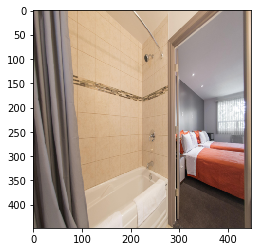

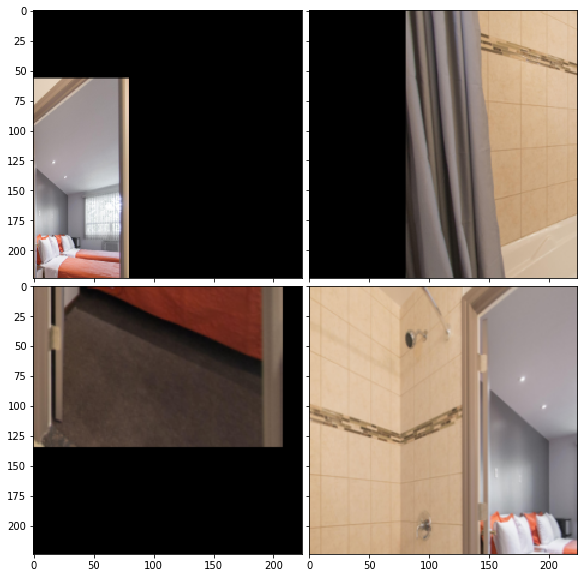

In [160]:
plot_attention(4)

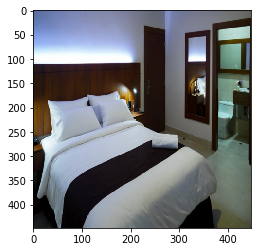

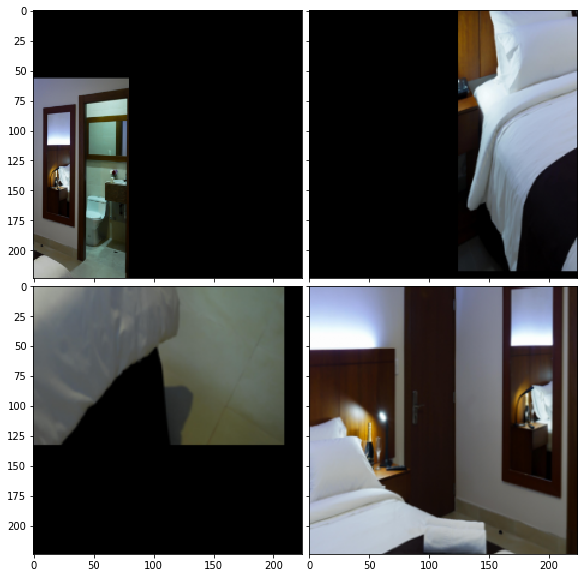

In [136]:
plot_attention(5)

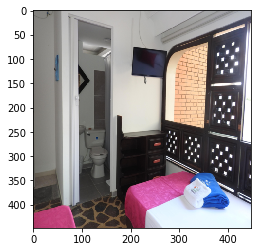

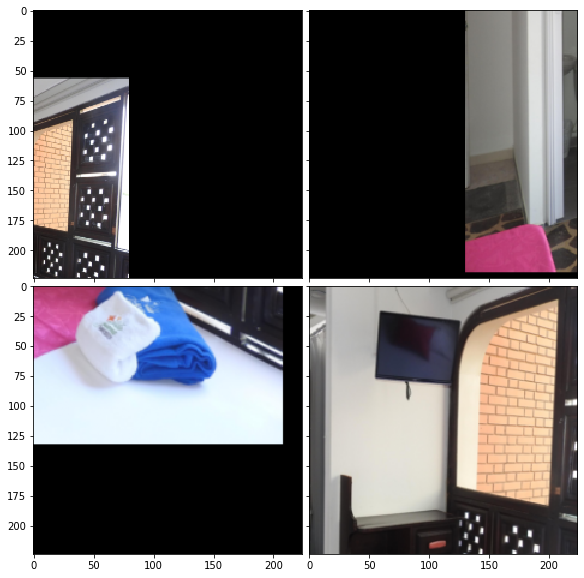

In [137]:
plot_attention(6)

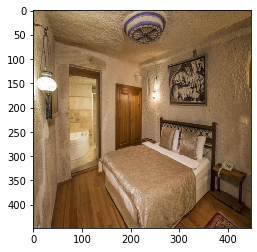

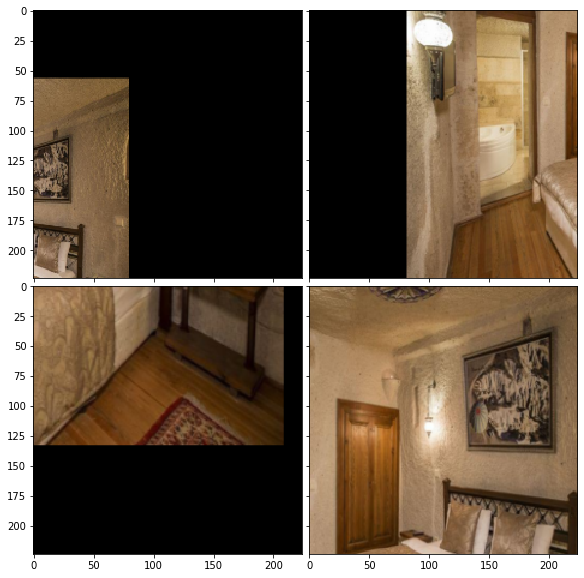

In [138]:
plot_attention(9)

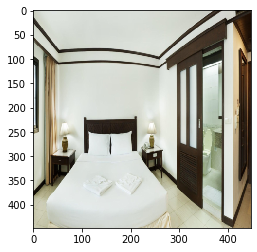

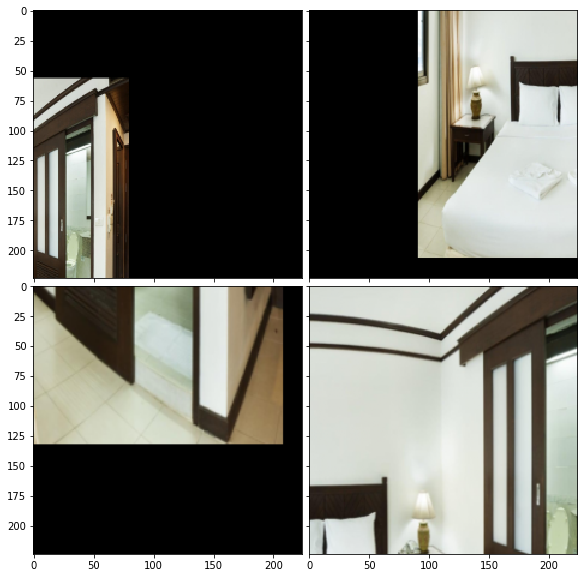

In [139]:
plot_attention(12)

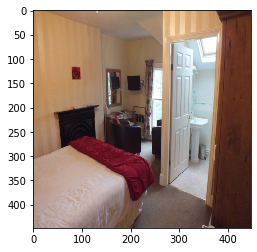

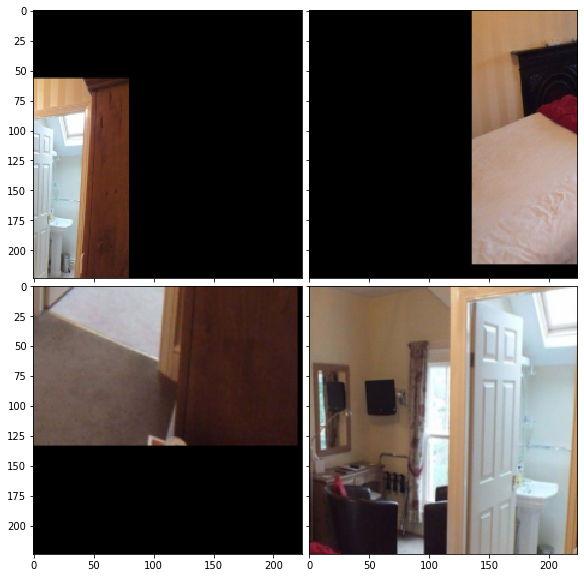

In [148]:
plot_attention(21)

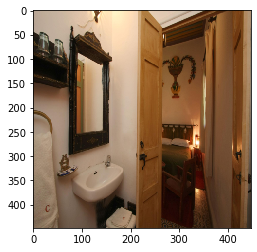

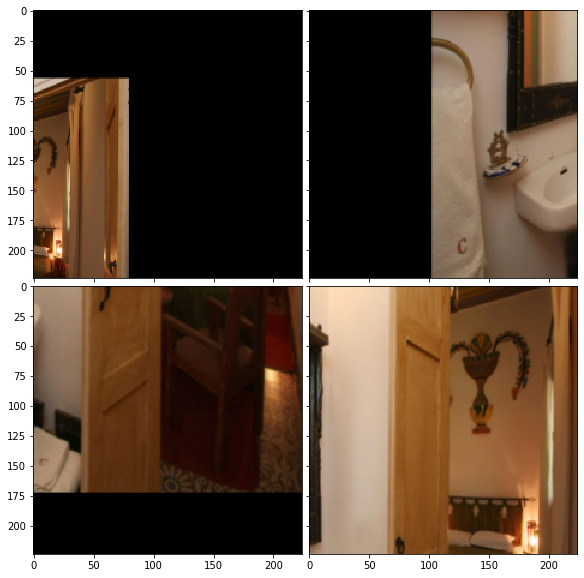

In [150]:
plot_attention(23)

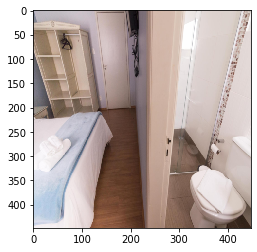

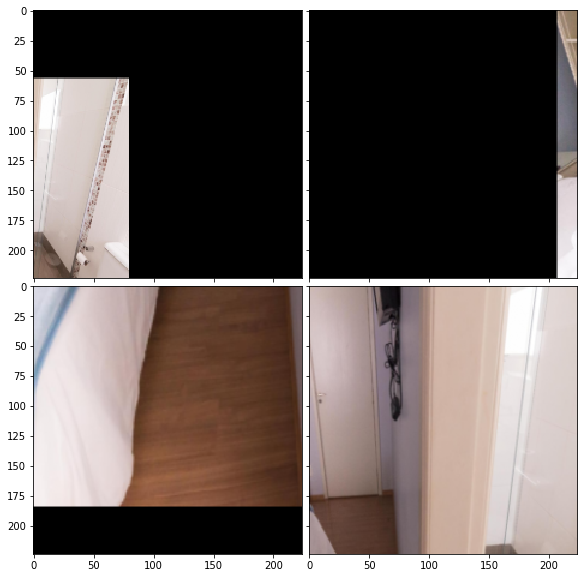

In [154]:
plot_attention(26)

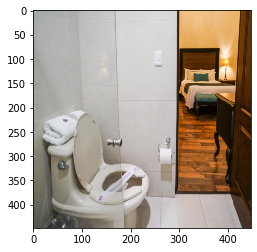

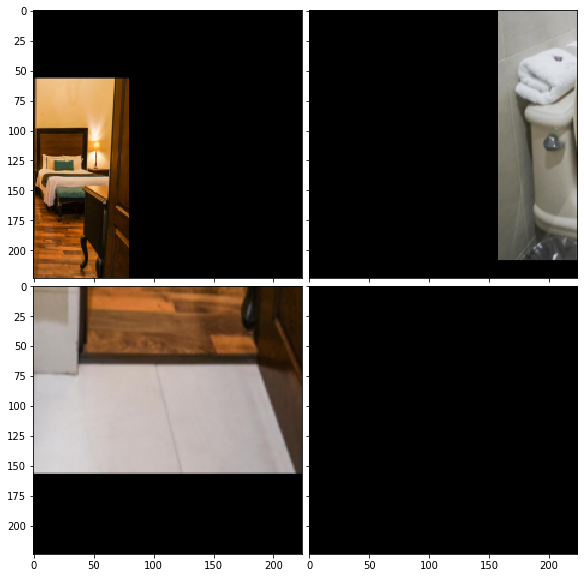

In [156]:
plot_attention(28)

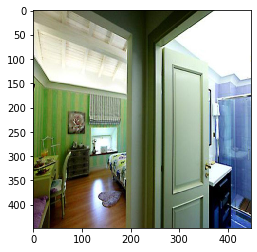

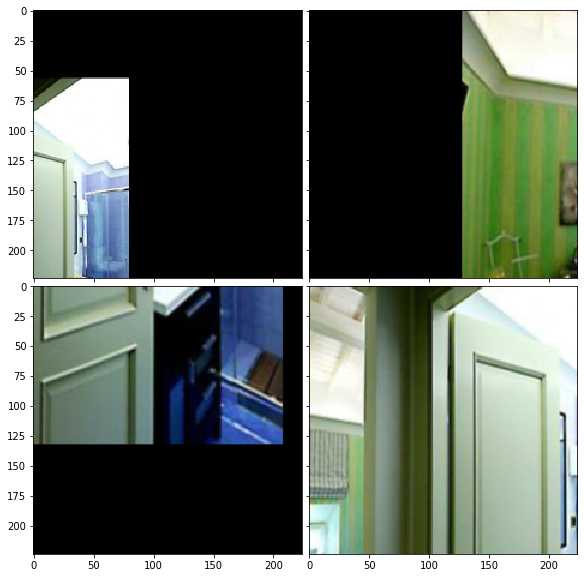

In [161]:
plot_attention(27)